In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

from nanonets import Simulation
from nanonets.utils import fft, harmonic_strength, total_harmonic_distortion, BLUE_COLOR
from matplotlib.animation import FuncAnimation

plt.style.use(["science","bright","grid"])
PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"

In [3]:
AMPLITUDE_LIST  = [0.02,0.03,0.04,0.05,0.06,0.07,0.08]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
N_PERIODS       = 100
SAMPLE_P_PERIOD = 40
N_ELECTRODES    = 8
N_NP            = 9

### Electric Current

In [4]:
e_type  = 'constant'
dts     = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time    = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data    = {amp : {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

### Single Signal

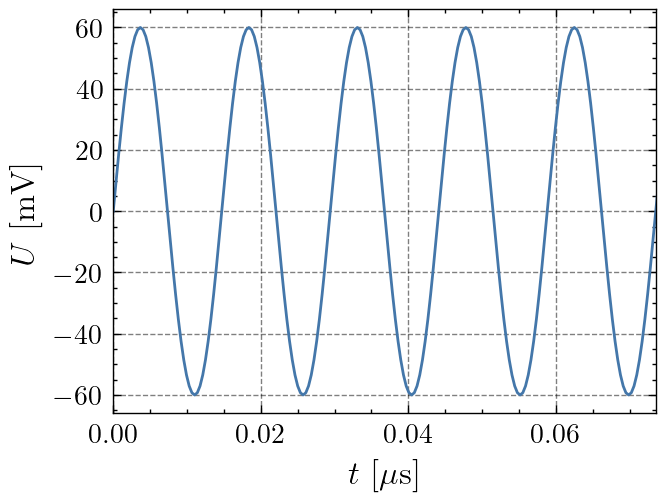

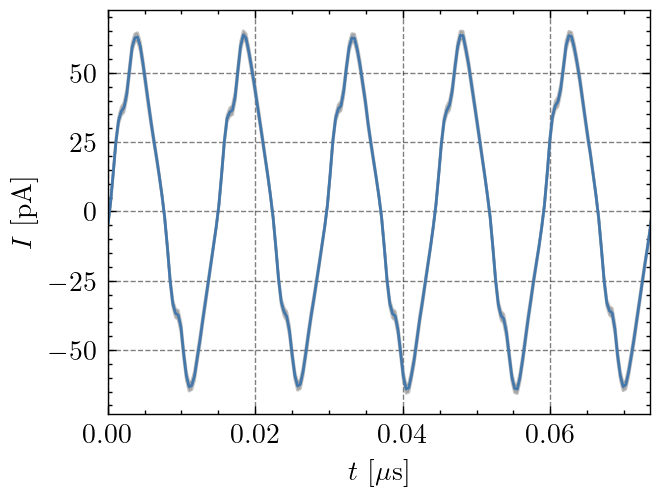

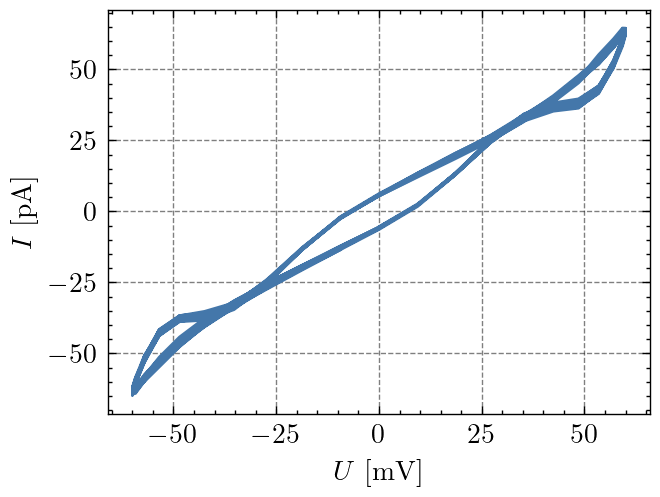

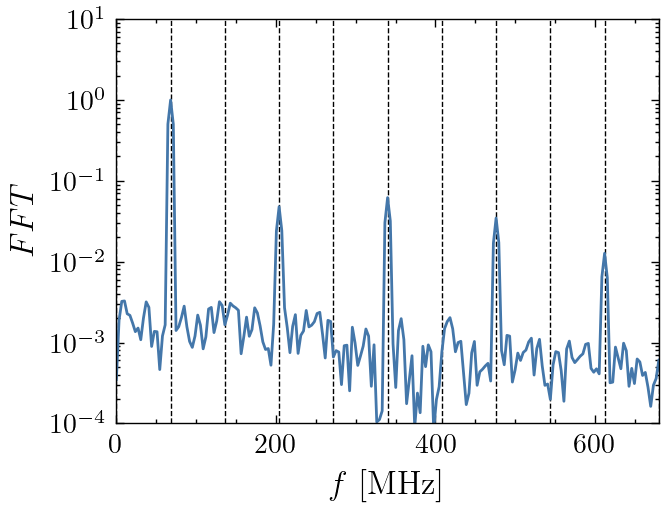

In [35]:
freq    = 68.0
amp     = 0.06
n_sk    = 80
n_p     = 5
t       = time[freq][:-1][:-n_sk*SAMPLE_P_PERIOD]*1e6
dt      = dts[freq]
x       = data[amp][freq]['E0'].values[n_sk*SAMPLE_P_PERIOD:]*1000
y       = data[amp][freq]['Observable'].values[n_sk*SAMPLE_P_PERIOD:]*1e-6
y_e     = data[amp][freq]['Error'].values[n_sk*SAMPLE_P_PERIOD:]*1e-6
xf, yf  = fft(y, dt=dt, use_hann=True)

fig = plt.figure(dpi=200)
ax1 = fig.add_subplot()
ax1.plot(t, x)
ax1.set_xlabel("$t$ [$\mu$s]", fontsize='large')
ax1.set_ylabel("$U$ [mV]", fontsize='large')
ax1.set_xlim(0, t[n_p*SAMPLE_P_PERIOD])

fig.savefig(f"plots/amp_freq/input/{e_type}_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/amp_freq/input/{e_type}_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/input/{e_type}_{freq:.3f}_{amp:.3f}.png", transparent=False)

fig = plt.figure(dpi=200)
ax1 = fig.add_subplot()
ax1.plot(t, y)
ax1.fill_between(t, y-y_e, y+y_e, alpha=0.5, color='grey')
ax1.set_xlabel("$t$ [$\mu$s]")
ax1.set_ylabel("$I$ [pA]")
ax1.set_xlim(0, t[n_p*SAMPLE_P_PERIOD])
fig.savefig(f"plots/amp_freq/output/{e_type}_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/amp_freq/output/{e_type}_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/output/{e_type}_{freq:.3f}_{amp:.3f}.png", transparent=False)

fig = plt.figure(dpi=200)
ax1 = fig.add_subplot()
ax1.plot(x, y)
ax1.set_xlabel("$U$ [mV]")
ax1.set_ylabel("$I$ [pA]")

fig.savefig(f"plots/amp_freq/phase/{e_type}_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/amp_freq/phase/{e_type}_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/phase/{e_type}_{freq:.3f}_{amp:.3f}.png", transparent=False)

fig, ax = plt.subplots(dpi=200)
for i in range(16):
    ax.vlines(i*freq, 1e-4, 1e1, color='black', ls='--', lw=.5)

ax.plot(xf*1e-6, yf/np.max(yf))
ax.set_yscale('log')
ax.set_xlim(0.0, 10*freq)
ax.set_ylim(1e-4, 1e1)
ax.set_xlabel("$f$ [MHz]", fontsize='large')
ax.set_ylabel("$FFT$", fontsize='large')
ax.grid(False)

fig.savefig(f"plots/amp_freq/fft/{e_type}_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/amp_freq/fft/{e_type}_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/fft/{e_type}_{freq:.3f}_{amp:.3f}.png", transparent=False)

### Parameter Space

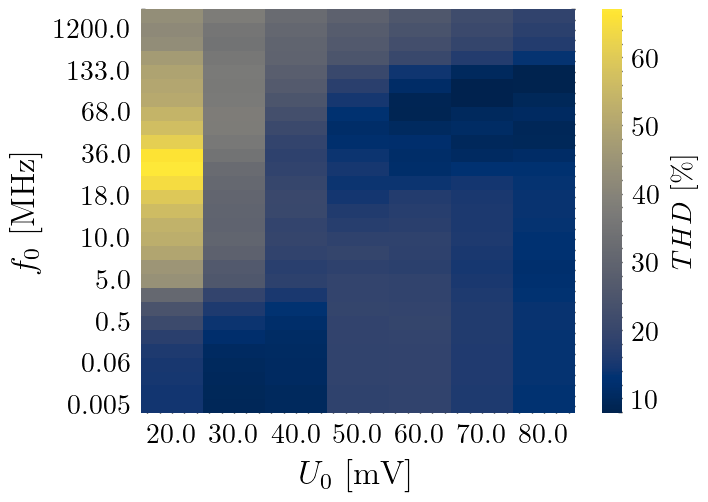

In [36]:
thd_arr = pd.DataFrame([[total_harmonic_distortion(signal=data[amp][freq]['Observable'].values, f0=freq*1e6, dt=dts[freq], N_f=18, snr_threshold=100) 
                         for amp in AMPLITUDE_LIST] for freq in FREQ_LIST_MHZ], columns=np.array(AMPLITUDE_LIST)*1000, index=FREQ_LIST_MHZ)
fig, ax = plt.subplots(dpi=200)
ax      = sns.heatmap(thd_arr, cmap='cividis', ax=ax, cbar_kws={'label':'$THD$ [\%]'}, annot=False)
# im      = ax.imshow(thd_arr, cmap='cividis', aspect='auto', interpolation='bilinear')
_       = plt.yticks(rotation=0)
_       = ax.set_ylabel("$f_0$ [MHz]", fontsize='large')
_       = ax.set_xlabel("$U_0$ [mV]", fontsize='large')
_       = ax.invert_yaxis()

fig.savefig(f"plots/amp_freq/{e_type}_thd_map.svg", transparent=True)
fig.savefig(f"plots/amp_freq/{e_type}_thd_map.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/{e_type}_thd_map.png", transparent=False)

In [77]:
areas = []
n_sk  = 80
for amp in AMPLITUDE_LIST:
    areas2 = []
    for freq in FREQ_LIST_MHZ:
        t = time[freq][:-1][:SAMPLE_P_PERIOD+1]*1e6
        x = data[amp][freq]['E0'].values[n_sk*SAMPLE_P_PERIOD:(n_sk+1)*SAMPLE_P_PERIOD+1]*1000
        y = data[amp][freq]['Observable'].values[n_sk*SAMPLE_P_PERIOD:(n_sk+1)*SAMPLE_P_PERIOD+1]*1e-6
        dVdt = np.gradient(x, t)
        area = np.trapz(y, x) 
        areas2.append((area/(amp**2))*1e-6)
    areas.append(areas2)

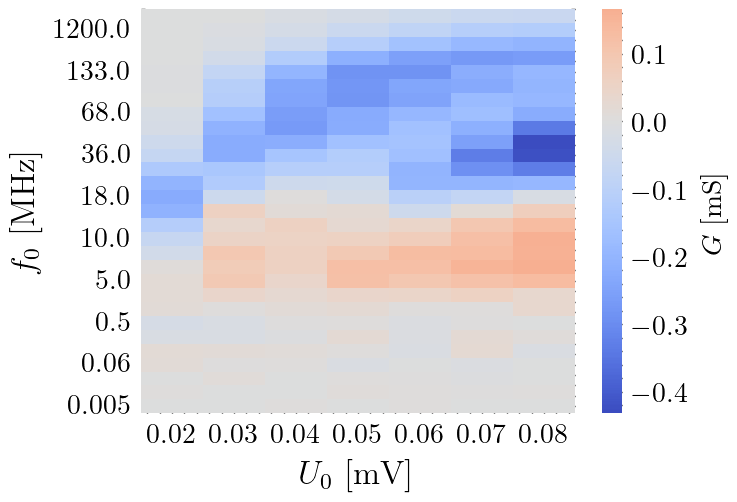

In [78]:
fig, ax = plt.subplots(dpi=200)
ax  = sns.heatmap(pd.DataFrame(areas, columns=FREQ_LIST_MHZ, index=AMPLITUDE_LIST).T, cmap='coolwarm',
                  ax=ax, center=0, cbar_kws={'label':"$G$ [mS]"})
_   = plt.yticks(rotation=0)
_   = ax.set_ylabel("$f_0$ [MHz]", fontsize='large')
_   = ax.set_xlabel("$U_0$ [mV]", fontsize='large')
_   = ax.invert_yaxis()

fig.savefig(f"plots/amp_freq/{e_type}_G_map.svg", transparent=True)
fig.savefig(f"plots/amp_freq/{e_type}_G_map.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/{e_type}_G_map.png", transparent=False)

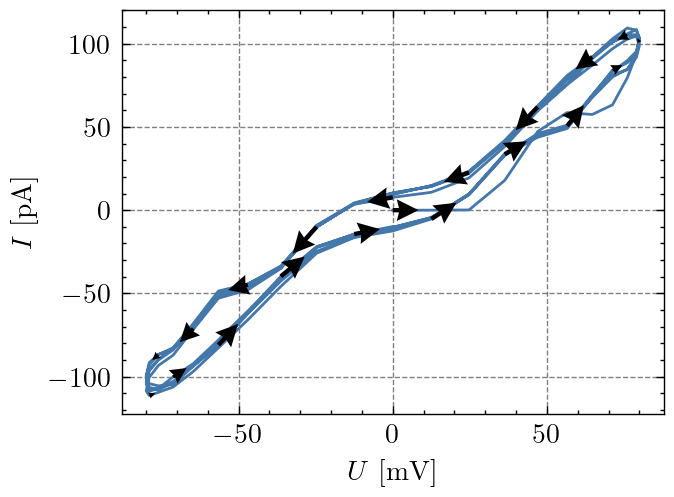

In [79]:
freq    = 36.
amp     = 0.08
n_sk    = 0
n_p     = 5
t       = time[freq][:-1][:n_p*SAMPLE_P_PERIOD+1]*1e6
x       = data[amp][freq]['E0'].values[n_sk*SAMPLE_P_PERIOD:(n_sk+n_p)*SAMPLE_P_PERIOD+1]*1000
y       = data[amp][freq]['Observable'].values[n_sk*SAMPLE_P_PERIOD:(n_sk+n_p)*SAMPLE_P_PERIOD+1]*1e-6

fig = plt.figure(dpi=200)
ax1 = fig.add_subplot()
ax1.plot(x, y)
ax1.set_xlabel("$U$ [mV]")
ax1.set_ylabel("$I$ [pA]")

num_arrows      = 20
arrow_indices   = np.linspace(0, len(x) - 2, num_arrows, dtype=int)

x_pos = x[arrow_indices]
y_pos = y[arrow_indices]
x_dir = x[arrow_indices + 1] - x_pos
y_dir = y[arrow_indices + 1] - y_pos

ax1.quiver(x_pos, y_pos, x_dir, y_dir, scale_units='xy', angles='xy', scale=1.5, width=0.008, headwidth=5, zorder=10)

fig.savefig(f"plots/amp_freq/lissajous/{e_type}_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/amp_freq/lissajous/{e_type}_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/lissajous/{e_type}_{freq:.3f}_{amp:.3f}.png", transparent=False)

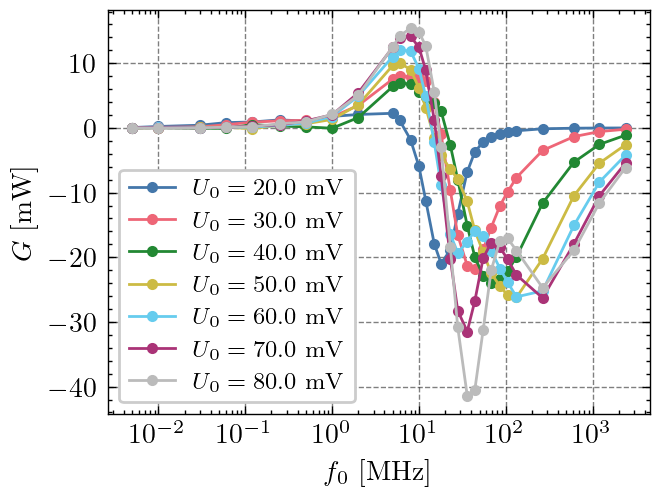

In [15]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for i, amp in enumerate(AMPLITUDE_LIST):
    ax.plot(FREQ_LIST_MHZ, areas[i], '.-', label=f'$U_0 = {amp*1000}$ mV')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$G$ [mW]")
ax.set_xscale("log")
ax.legend(fontsize='small')

fig.savefig(f"plots/amp_freq/{e_type}_G_vs_freq.svg", transparent=True)
fig.savefig(f"plots/amp_freq/{e_type}_G_vs_freq.pdf", transparent=True)

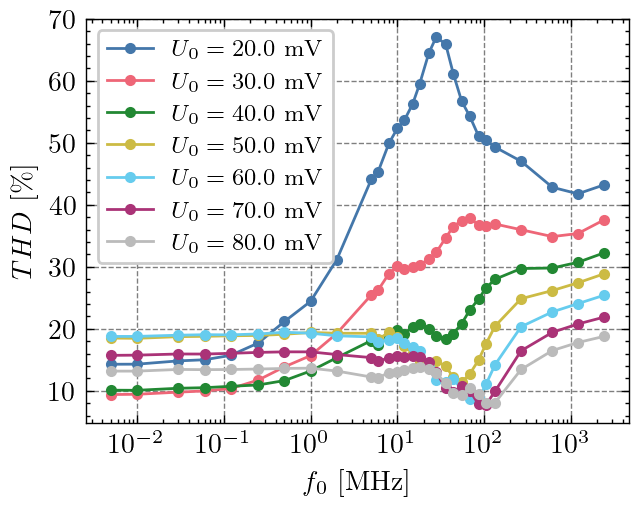

In [17]:
fig, ax = plt.subplots(dpi=200)
for amp in AMPLITUDE_LIST:
    ax.plot(thd_arr[amp*1000], '.-', label=f'$U_0 = {amp*1000}$ mV')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$THD$ [\%]")
ax.set_xscale("log")
ax.legend(fontsize='small')

fig.savefig(f"plots/amp_freq/{e_type}_thd_vs_freq.svg", transparent=True)
fig.savefig(f"plots/amp_freq/{e_type}_thd_vs_freq.pdf", transparent=True)

### Internal Dynamics

In [10]:
topo = {"Nx": N_NP,"Ny": N_NP,
        "e_pos": [
            [(N_NP-1)//2, 0],
            [0, 0],
            [N_NP-1, 0],
            [0, (N_NP-1)//2],
            [N_NP-1, (N_NP-1)//2],
            [0, N_NP-1],
            [N_NP-1, N_NP-1],
            [(N_NP-1)//2, N_NP-1]
            ],
        "electrode_type": ['constant']*8}
sim_class   = Simulation(topo)
cap_mat     = sim_class.get_capacitance_matrix()
e_charge    = sim_class.ELE_CHARGE_A_C

In [4]:
states = {amp : {freq : pd.read_csv(f"{PATH}mean_state_Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

- $U_0 = 20$ mV
- $f_0 = 28$ MHz

In [59]:
amp     = 0.02
freq    = 28.0
n_sk    = 5
n_p     = 5
np_idx  = [4+i*9 for i in range(9)]
phi_vec = states[amp][freq].iloc[:,N_ELECTRODES:].values
q_vec   = (cap_mat @ phi_vec.T).T/e_charge
q_np    = q_vec[n_sk*SAMPLE_P_PERIOD:,np_idx].copy()
t       = time[freq][:-1][:-n_sk*SAMPLE_P_PERIOD]*1e6
x       = data[amp][freq]['E0'].values[n_sk*SAMPLE_P_PERIOD:]*1000
y       = data[amp][freq]['Observable'].values[n_sk*SAMPLE_P_PERIOD:]*1e-6

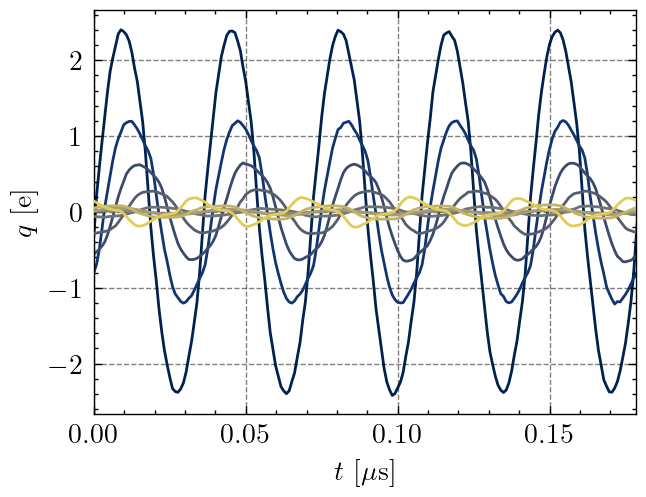

In [49]:
cmap    = plt.get_cmap('cividis')
fig, ax = plt.subplots(dpi=200)
for i in range(9):
    ax.plot(t, q_np[:,i], zorder=i, color=cmap(i/9))
ax.set_xlim(0, t[n_p*SAMPLE_P_PERIOD])
ax.set_ylabel("$q$ [e]")
ax.set_xlabel("$t$ [$\mu$s]")

fig.savefig(f"plots/amp_freq/internal/{e_type}_charge_dyn.svg", transparent=True)
fig.savefig(f"plots/amp_freq/internal/{e_type}_charge_dyn.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/internal/{e_type}_charge_dyn.png", transparent=False)

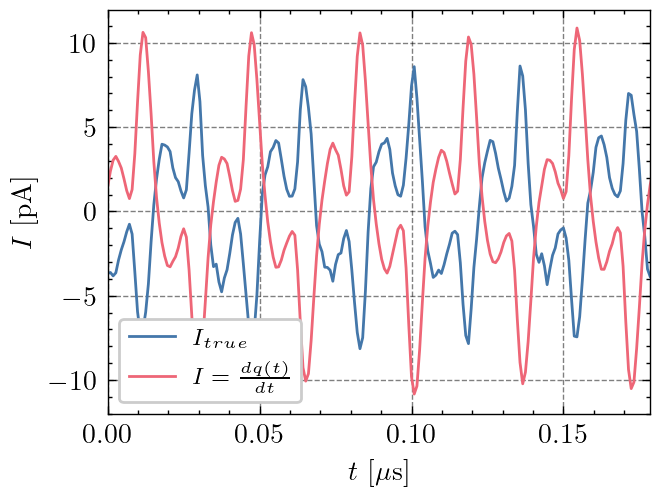

In [167]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, np.gradient(q_np[:,-1], t)*e_charge, label='$I_{true}$')
ax.plot(t, y, label='$I = \\frac{dq(t)}{dt}$')
ax.set_xlim(0, t[n_p*SAMPLE_P_PERIOD])
ax.set_ylabel("$I$ [pA]")
ax.set_xlabel("$t$ [$\mu$s]")
ax.legend(fontsize='small')

fig.savefig(f"plots/amp_freq/internal/{e_type}_I_true_vs_I_deriv.svg", transparent=True)
fig.savefig(f"plots/amp_freq/internal/{e_type}_I_true_vs_I_deriv.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/internal/{e_type}_I_true_vs_I_deriv.png", transparent=False)

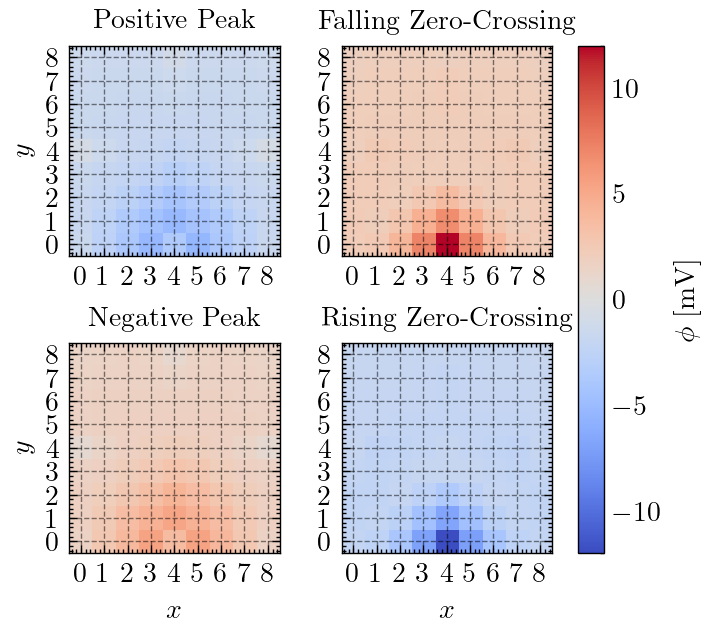

In [157]:
t_points    = [5*SAMPLE_P_PERIOD,int(5.25*SAMPLE_P_PERIOD),int(5.5*SAMPLE_P_PERIOD),int(5.75*SAMPLE_P_PERIOD)]
phi_t_pts   = phi_vec[t_points,:].copy()

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*1.2)
# fig.set_figwidth(fig.get_figwidth()*1.2)
tt  = ['Positive Peak','Falling Zero-Crossing', 'Negative Peak', 'Rising Zero-Crossing']
axs = []
for i in range(4):
    ax  = fig.add_subplot(2, 2, i+1)
    im  = ax.imshow(1000*phi_t_pts[i,:].reshape(9,9), cmap='coolwarm', vmin=-12, vmax=12)
    ax.invert_yaxis()
    if i % 2 == 0:
        ax.set_ylabel("$y$")
    if i >= 2:
        ax.set_xlabel("$x$")
    ax.set_title(tt[i], fontsize=10)
    ax.set_xticks(np.arange(9))
    ax.set_yticks(np.arange(9))
    axs.append(ax)
fig.colorbar(im, ax=axs, label='$\phi$ [mV]', orientation='vertical')
fig.savefig(f"plots/amp_freq/internal/{e_type}_pot_landscape.svg", transparent=True)
fig.savefig(f"plots/amp_freq/internal/{e_type}_pot_landscape.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/internal/{e_type}_pot_landscape.png", transparent=False)

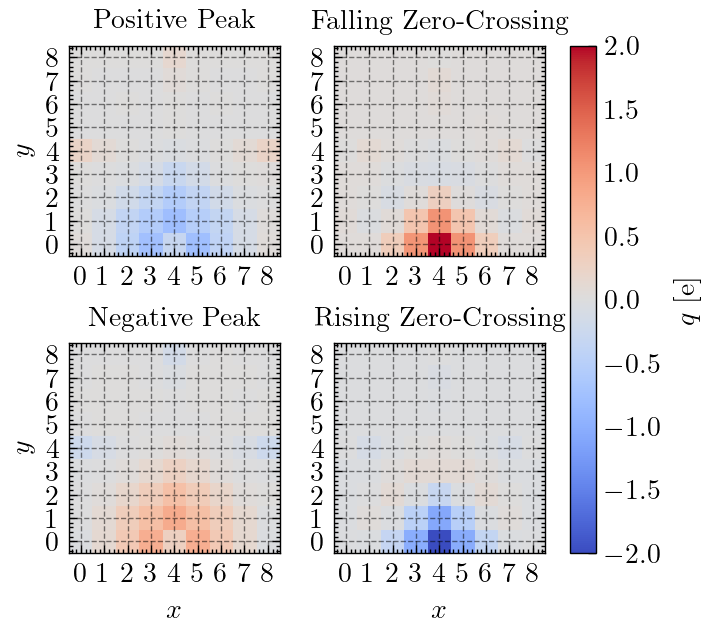

In [145]:
t_points    = [5*SAMPLE_P_PERIOD,int(5.25*SAMPLE_P_PERIOD),int(5.5*SAMPLE_P_PERIOD),int(5.75*SAMPLE_P_PERIOD)]
q_t_pts     = q_vec[t_points,:].copy()

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*1.2)
# fig.set_figwidth(fig.get_figwidth()*1.2)
tt  = ['Positive Peak','Falling Zero-Crossing', 'Negative Peak', 'Rising Zero-Crossing']
axs = []
for i in range(4):
    ax  = fig.add_subplot(2, 2, i+1)
    im  = ax.imshow(q_t_pts[i,:].reshape(9,9), cmap='coolwarm', vmin=-2, vmax=2)
    ax.invert_yaxis()
    if i % 2 == 0:
        ax.set_ylabel("$y$")
    if i >= 2:
        ax.set_xlabel("$x$")
    ax.set_title(tt[i], fontsize=10)
    ax.set_xticks(np.arange(9))
    ax.set_yticks(np.arange(9))
    axs.append(ax)
fig.colorbar(im, ax=axs, label='$q$ [e]', orientation='vertical')
fig.savefig(f"plots/amp_freq/internal/{e_type}_charge_landscape.svg", transparent=True)
fig.savefig(f"plots/amp_freq/internal/{e_type}_charge_landscape.pdf", transparent=False)
fig.savefig(f"plots/amp_freq/internal/{e_type}_charge_landscape.png", transparent=False)

In [19]:
thd_net = {amp : pd.DataFrame([[total_harmonic_distortion(states[amp][freq].iloc[:,(8+i)].values, freq*1e6, dts[freq], N_f=18) for i in range(81)]
                  for freq in FREQ_LIST_MHZ], index=FREQ_LIST_MHZ).T for amp in AMPLITUDE_LIST}

/tmp/ipykernel_30578/4230434067.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=f"$U_0 = {amp*1000}$ mV", loc='upper right')


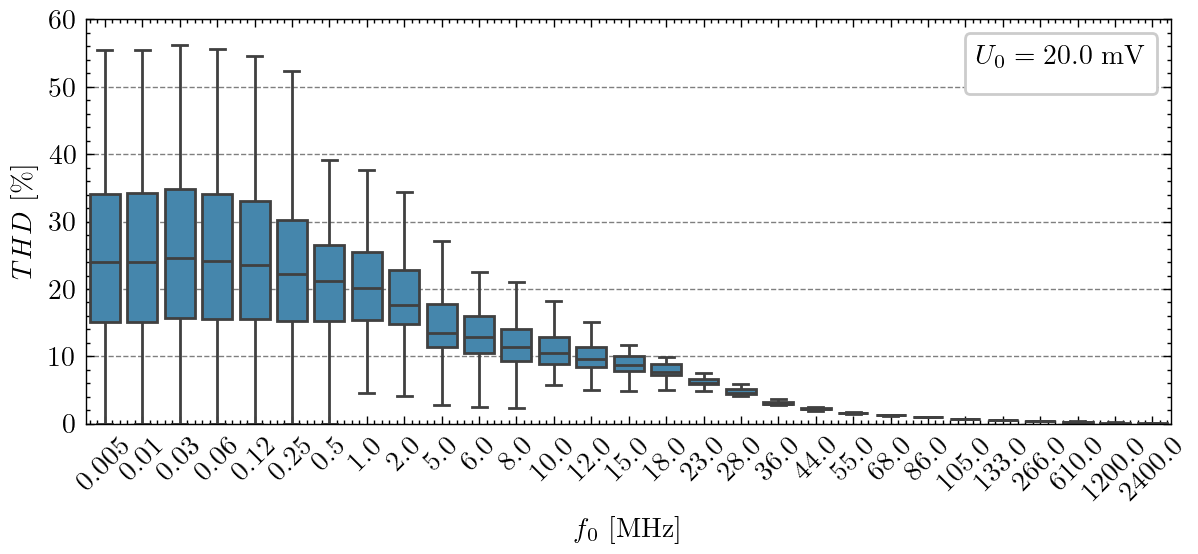

In [47]:
amp     = 0.02
fig, ax = plt.subplots(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = sns.boxplot(data=thd_net[amp], color=BLUE_COLOR, fliersize=0)
_   = ax.set_ylim(0,60)
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.set_ylabel("$THD$ [\%]")
_   = plt.xticks(rotation=45)
ax.legend(title=f"$U_0 = {amp*1000}$ mV", loc='upper right')

fig.savefig(f"plots/amp_freq/{e_type}_net_thd_vs_freq_{amp}.svg", transparent=True)
fig.savefig(f"plots/amp_freq/{e_type}_net_thd_vs_freq_{amp}.pdf", transparent=True)

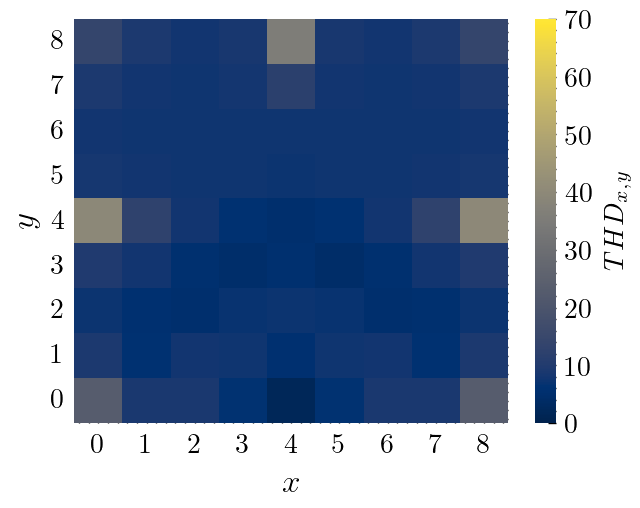

In [24]:
freq    = 18.0
amp     = 0.02

fig, ax = plt.subplots(dpi=200)
ax  = sns.heatmap(thd_net[amp][freq].values.reshape(9,9), cmap='cividis', ax=ax, cbar_kws={'label':'$THD_{x,y}$'}, vmin=0, vmax=70)
_   = plt.yticks(rotation=0)
_   = ax.set_ylabel("$y$", fontsize='large')
_   = ax.set_xlabel("$x$", fontsize='large')
_   = ax.invert_yaxis()

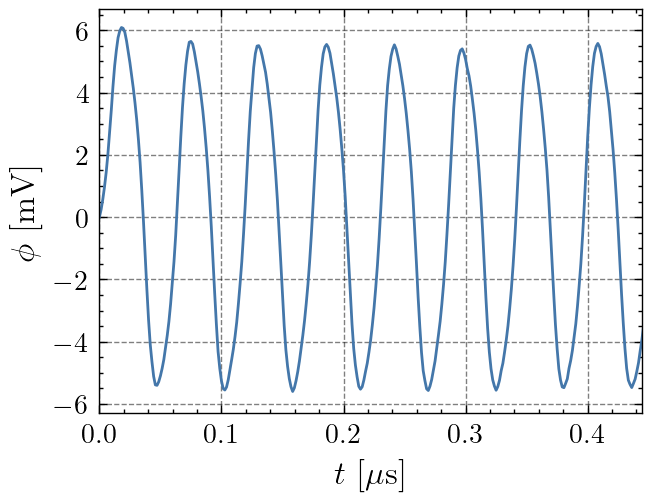

In [32]:
freq = 18.0
amp  = 0.02
n_p  = 8

x = 3
y = 3
i = 4*y + x + N_ELECTRODES
y = states[amp][freq].iloc[:,i].values*1000
t = time[freq][:-1]*1e6

fig, ax = plt.subplots(dpi=200)
ax.plot(t, y)
_ = ax.set_xlabel("$t$ [$\mu$s]", fontsize='large')
_ = ax.set_ylabel("$\phi$ [mV]", fontsize='large')
_ = ax.set_xlim(0, t[n_p*SAMPLE_P_PERIOD])

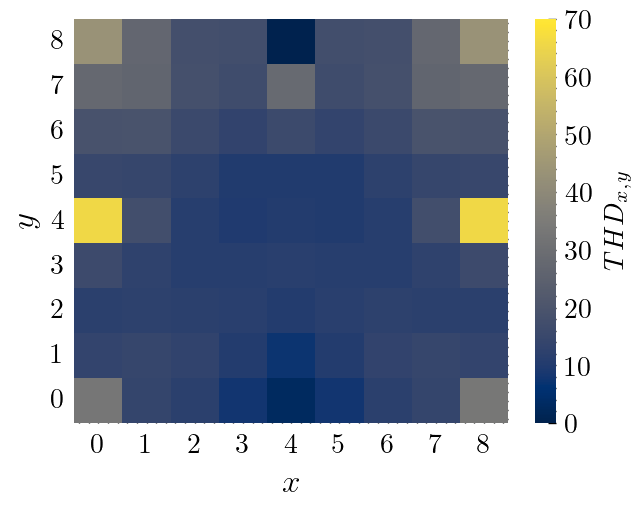

In [23]:
freq    = 5.0
amp     = 0.02

fig, ax = plt.subplots(dpi=200)
ax  = sns.heatmap(thd_net[amp][freq].values.reshape(9,9), cmap='cividis', ax=ax, cbar_kws={'label':'$THD_{x,y}$'}, vmin=0, vmax=70)
_   = plt.yticks(rotation=0)
_   = ax.set_ylabel("$y$", fontsize='large')
_   = ax.set_xlabel("$x$", fontsize='large')
_   = ax.invert_yaxis()

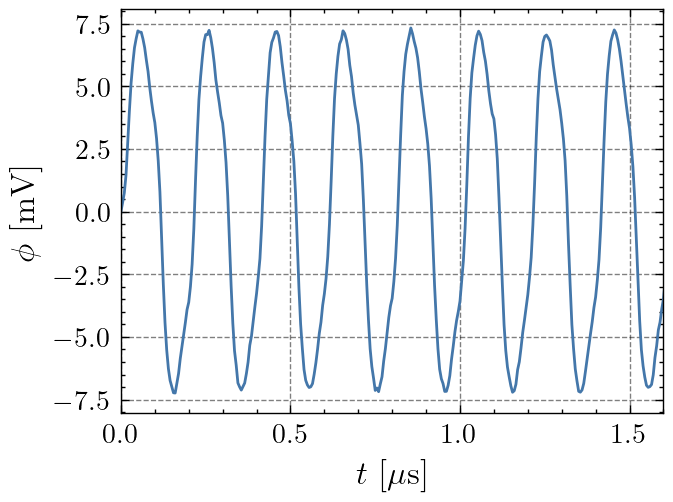

In [36]:
freq = 5.0
amp  = 0.02
n_p  = 8

x = 3
y = 3
i = 4*y + x + N_ELECTRODES
y = states[amp][freq].iloc[:,i].values*1000
t = time[freq][:-1]*1e6

fig, ax = plt.subplots(dpi=200)
ax.plot(t, y)
_ = ax.set_xlabel("$t$ [$\mu$s]", fontsize='large')
_ = ax.set_ylabel("$\phi$ [mV]", fontsize='large')
_ = ax.set_xlim(0, t[n_p*SAMPLE_P_PERIOD])

In [37]:
def animate_potential_landscape(potential_data_list, t_vector: np.ndarray,
                                title_prefix: str = "Potential Landscape",
                                output_filename: str = "potential_animation.mp4"):
    """
    Creates and saves an animation of the 9x9 potential landscape over time.

    Args:
        potential_data_list (List[np.ndarray]): A list of 2D numpy arrays, where each
                                             array has shape (9, 9) and represents
                                             the node potentials at a single time step.
        t_vector (np.ndarray): 1D numpy array of time values corresponding to the frames.
        title_prefix (str): A string to prepend to the animation title (e.g., "Active Regime").
        output_filename (str): The filename to save the animation (e.g., 'animation.mp4' or 'animation.gif').
                               Requires a writer like ffmpeg or imagemagick.
    """
    
    with plt.style.context(["science","bright","grid"]):

        # --- Convert list of 2D arrays to a single 3D numpy array for easier handling ---
        try:
            potential_data_TXY = np.array(potential_data_list)
        except Exception as e:
            raise TypeError(f"Could not convert the input list to a NumPy array. Please ensure it's a list of 2D arrays. Error: {e}")

        # Basic validation
        if potential_data_TXY.ndim != 3 or potential_data_TXY.shape[1:] != (N_NP, N_NP):
            raise ValueError("Input data must resolve to a 3D array of shape (num_timesteps, 9, 9).")

        num_timesteps = potential_data_TXY.shape[0]

        # --- Setup the plot ---
        fig, ax = plt.subplots(layout='tight')

        # Determine a fixed color scale based on the global min/max of the entire dataset.
        # This is CRITICAL to prevent the color bar from flickering.
        vmin = -np.max(np.abs(potential_data_TXY))
        vmax = np.max(np.abs(potential_data_TXY))

        # Display the first frame (t=0)
        # We use origin='lower' to match your coordinate system (y=0 at the bottom).
        im = ax.imshow(potential_data_TXY[0, :, :], vmin=vmin, vmax=vmax,
                        cmap='coolwarm', origin='lower', interpolation='bicubic')

        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_xticks(np.arange(N_NP))
        ax.set_yticks(np.arange(N_NP))

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("$\phi$ [mV]")

        time_text = ax.set_title("")

        # --- Animation update function ---
        def update(frame_index):
            data_slice = potential_data_TXY[frame_index, :, :]
            im.set_array(data_slice)
            current_time = t_vector[frame_index]
            time_text.set_text(f'Time: {1000*current_time:.1f} ms')
            return [im, time_text]

        # --- Create and save the animation ---
        print("Creating animation... This may take a few moments.")

        if len(t_vector) > 1:
            dt = (t_vector[1] - t_vector[0]) * 1000  # interval in ms
        else:
            dt = 50  # default to 20 fps

        ani = FuncAnimation(fig, update, frames=num_timesteps,
                            interval=dt, blit=True, repeat=True)

        try:
            ani.save(output_filename, writer='ffmpeg', fps=15, dpi=150)
            print(f"Animation successfully saved to '{output_filename}'")
        except Exception as e:
            print(f"Error saving animation: {e}")
            print("Please ensure you have a writer like 'ffmpeg' installed and accessible in your system's PATH.")
            
        plt.close(fig)

In [48]:
freq    = 18.0
amp     = 0.02
n_p     = 8
f_name  = f"pot_landscape_{freq}_{amp}.gif"
y       = states[amp][freq].iloc[:SAMPLE_P_PERIOD*n_p,N_ELECTRODES:].values*1000

y_t = [np.array(y_t).reshape(9,9) for y_t in y.tolist()]
t   = time[freq][:SAMPLE_P_PERIOD*n_p]*1e6

animate_potential_landscape(y_t, t, output_filename=f_name)

MovieWriter ffmpeg unavailable; using Pillow instead.


Creating animation... This may take a few moments.
Animation successfully saved to 'pot_landscape_18.0_0.02.gif'


In [56]:
currents = {amp : {freq : pd.read_csv(f"{PATH}net_currents_Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

In [69]:
freq    = 28.0
amp     = 0.02
skip_p  = 10
pot_evo = states[amp][freq].iloc[skip_p*SAMPLE_P_PERIOD:(skip_p+1)*SAMPLE_P_PERIOD]
cur_evo = currents[amp][freq].iloc[skip_p*SAMPLE_P_PERIOD:(skip_p+1)*SAMPLE_P_PERIOD]

In [101]:
arr = np.zeros(shape=cur_evo.shape)
for i, col in enumerate(cur_evo.columns):
    node1   = eval(col)[0]
    node2   = eval(col)[1]
    pot1    = pot_evo[f"{node1}"].values
    pot2    = pot_evo[f"{node2}"].values
    currs   = cur_evo[col].values

    arr[:,i]    = currs*(pot2-pot1)
power = pd.DataFrame(arr, columns=cur_evo.columns).mean()
power

(0, 12)    -601354.351276
(1, 8)       -3867.788052
(2, 16)      -3685.674065
(3, 44)      -3773.089500
(4, 52)      -3832.321086
                ...      
(87, 86)        -0.171619
(87, 88)        -7.332524
(88, 6)       -206.476119
(88, 79)        -7.010691
(88, 87)        -5.129529
Length: 304, dtype: float64

### Voltage

In [151]:
AMPLITUDE_LIST  = [0.02]#,0.02,0.03,0.04,0.05,0.06,0.07,0.08]
FREQ_LIST_MHZ   = [0.002,0.005,266.,610.,1200.,2400.,4800.,9600.]
# FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
# FREQ_LIST_MHZ   = [0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.]

e_type  = 'floating'
dts     = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time    = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data    = {amp : {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

FileNotFoundError: [Errno 2] No such file or directory: '/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq/Nx=9_Ny=9_Ne=8_0.002_0.020_floating.csv'

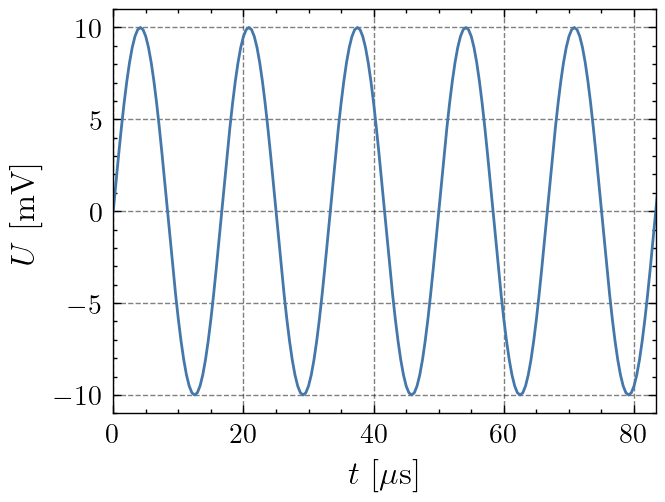

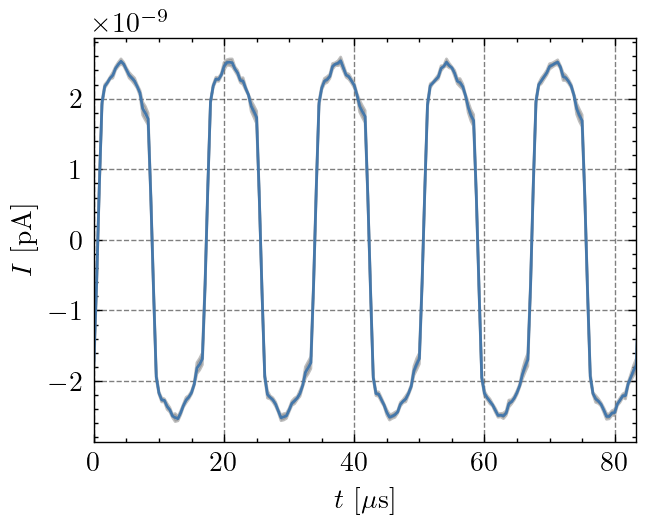

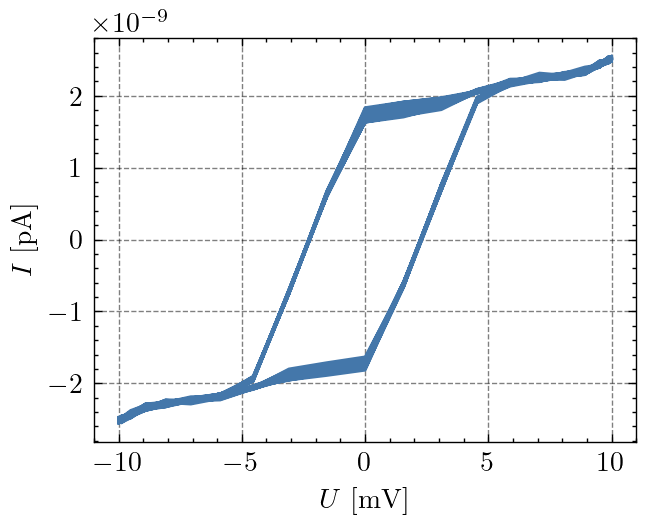

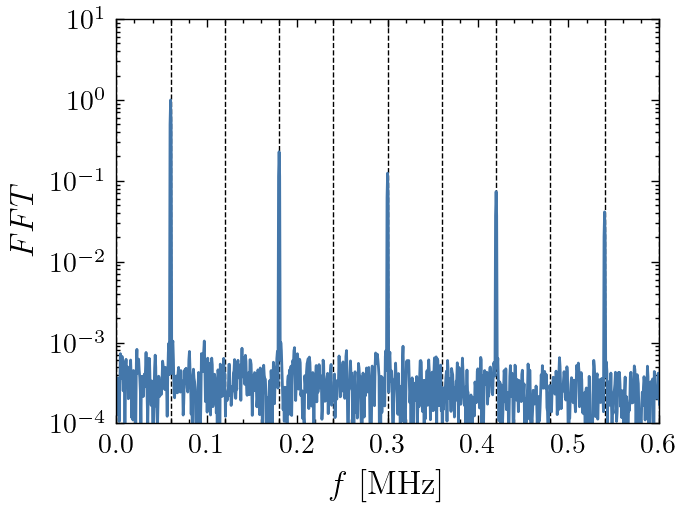

In [144]:
freq    = 0.06  #MAX
amp     = 0.01  #MAX
# freq    = 105.0 #MIN
# amp     = 0.08  #MIN
n_sk    = 5
n_p     = 5
t       = time[freq][:-1][:-n_sk*SAMPLE_P_PERIOD]*1e6
dt      = dts[freq]
x       = data[amp][freq]['E0'].values[n_sk*SAMPLE_P_PERIOD:]*1000
y       = data[amp][freq]['Observable'].values[n_sk*SAMPLE_P_PERIOD:]*1e-6
y_e     = data[amp][freq]['Error'].values[n_sk*SAMPLE_P_PERIOD:]*1e-6
xf, yf  = fft(y, dt=dt, use_hann=True)

fig = plt.figure(dpi=200)
ax1 = fig.add_subplot()
ax1.plot(t, x)
ax1.set_xlabel("$t$ [$\mu$s]", fontsize='large')
ax1.set_ylabel("$U$ [mV]", fontsize='large')
ax1.set_xlim(0, t[n_p*SAMPLE_P_PERIOD])

fig.savefig(f"plots/amp_freq/{e_type}_input_{freq:.3f}_{amp:.3f}.svg", transparent=True)

fig = plt.figure(dpi=200)
ax1 = fig.add_subplot()
ax1.plot(t, y)
ax1.fill_between(t, y-y_e, y+y_e, alpha=0.5, color='grey')
ax1.set_xlabel("$t$ [$\mu$s]")
ax1.set_ylabel("$I$ [pA]")
ax1.set_xlim(0, t[n_p*SAMPLE_P_PERIOD])
fig.savefig(f"plots/amp_freq/{e_type}_output_{freq:.3f}_{amp:.3f}.svg", transparent=True)

fig = plt.figure(dpi=200)
ax1 = fig.add_subplot()
ax1.plot(x, y)
ax1.set_xlabel("$U$ [mV]")
ax1.set_ylabel("$I$ [pA]")

fig.savefig(f"plots/amp_freq/{e_type}_phase_{freq:.3f}_{amp:.3f}.svg", transparent=True)

fig, ax = plt.subplots(dpi=200)
for i in range(16):
    ax.vlines(i*freq, 1e-4, 1e1, color='black', ls='--', lw=.5)

ax.plot(xf*1e-6, yf/np.max(yf))
ax.set_yscale('log')
ax.set_xlim(0.0, 10*freq)
ax.set_ylim(1e-4, 1e1)
ax.set_xlabel("$f$ [MHz]", fontsize='large')
ax.set_ylabel("$FFT$", fontsize='large')
ax.grid(False)

# fig.savefig(f"plots/amp_freq/{e_type}_fft_{freq:.3f}_{amp:.3f}.svg", transparent=True)

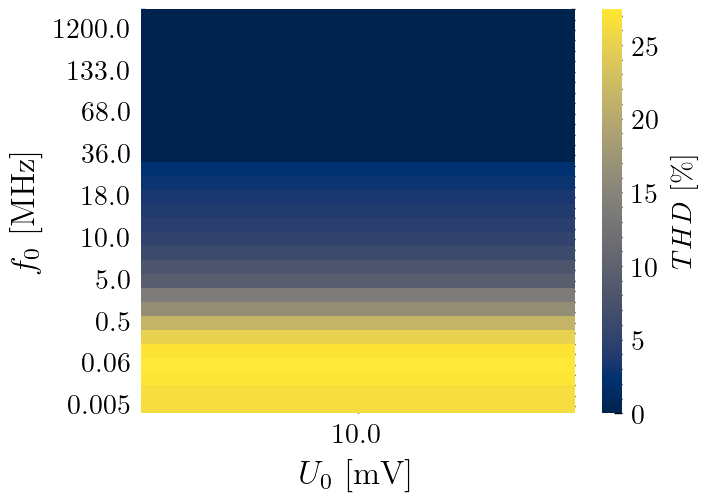

In [145]:
thd_arr = pd.DataFrame([[total_harmonic_distortion(signal=data[amp][freq]['Observable'].values, f0=freq*1e6, dt=dts[freq], N_f=18) 
                         for amp in AMPLITUDE_LIST] for freq in FREQ_LIST_MHZ], columns=np.array(AMPLITUDE_LIST)*1000, index=FREQ_LIST_MHZ)
fig, ax = plt.subplots(dpi=200)
ax      = sns.heatmap(thd_arr, cmap='cividis', ax=ax, cbar_kws={'label':'$THD$ [\%]'}, annot=False)
_       = plt.yticks(rotation=0)
_       = ax.set_ylabel("$f_0$ [MHz]", fontsize='large')
_       = ax.set_xlabel("$U_0$ [mV]", fontsize='large')
_       = ax.invert_yaxis()

# fig.savefig(f"plots/amp_freq/{e_type}_thd_map.svg", transparent=True)
# fig.savefig(f"plots/amp_freq/{e_type}_thd_map.pdf", transparent=True)

In [146]:
areas = []
n_sk  = 5
for amp in AMPLITUDE_LIST:
    areas2 = []
    for freq in FREQ_LIST_MHZ:
        t = time[freq][:-1][:-n_sk*SAMPLE_P_PERIOD]*1e6
        x = data[amp][freq]['E0'].values[n_sk*SAMPLE_P_PERIOD:]
        y = data[amp][freq]['Observable'].values[n_sk*SAMPLE_P_PERIOD:]
        dVdt = np.gradient(x, t)
        area = np.trapz(y, x) 
        areas2.append((area/(amp**2)))
    areas.append(areas2)

/tmp/ipykernel_30578/3031475980.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(y, x)


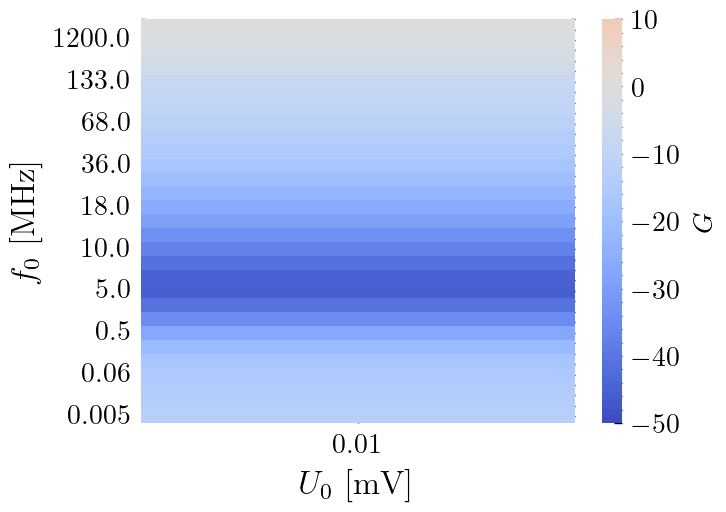

In [147]:
fig, ax = plt.subplots(dpi=200)
ax  = sns.heatmap(pd.DataFrame(areas, columns=FREQ_LIST_MHZ, index=AMPLITUDE_LIST).T, cmap='coolwarm',
                  ax=ax, center=0, cbar_kws={'label':"$G$"}, vmin=-50, vmax=10)
_   = plt.yticks(rotation=0)
_   = ax.set_ylabel("$f_0$ [MHz]", fontsize='large')
_   = ax.set_xlabel("$U_0$ [mV]", fontsize='large')
_   = ax.invert_yaxis()

# fig.savefig(f"plots/amp_freq/{e_type}_G_map.svg", transparent=True)
# fig.savefig(f"plots/amp_freq/{e_type}_G_map.pdf", transparent=True)

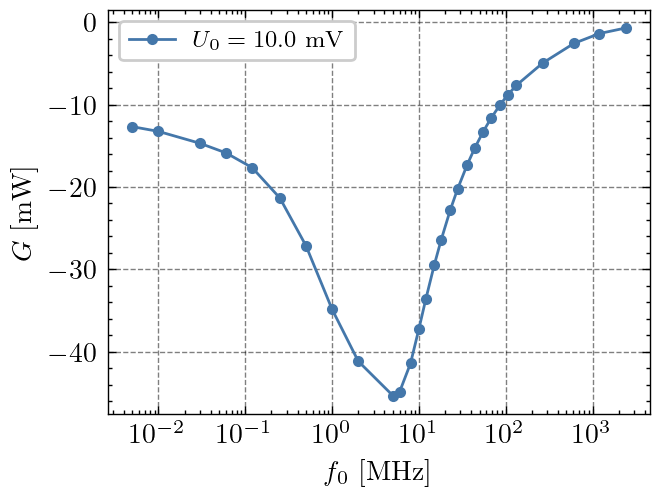

In [148]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for i, amp in enumerate(AMPLITUDE_LIST):
    ax.plot(FREQ_LIST_MHZ, areas[i], '.-', label=f'$U_0 = {amp*1000}$ mV')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$G$ [mW]")
ax.set_xscale("log")
ax.legend(fontsize='small')

# fig.savefig(f"plots/amp_freq/{e_type}_G_vs_freq.svg", transparent=True)
# fig.savefig(f"plots/amp_freq/{e_type}_G_vs_freq.pdf", transparent=True)

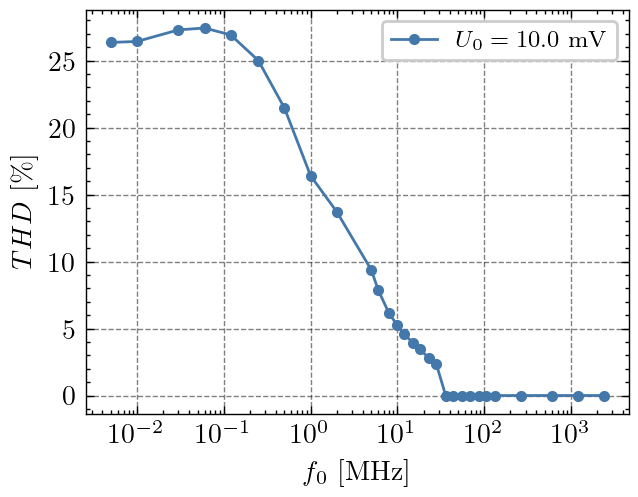

In [149]:
fig, ax = plt.subplots(dpi=200)
for amp in AMPLITUDE_LIST:
    ax.plot(thd_arr[amp*1000], '.-', label=f'$U_0 = {amp*1000}$ mV')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$THD$ [\%]")
ax.set_xscale("log")
ax.legend(fontsize='small')

# fig.savefig(f"plots/amp_freq/{e_type}_thd_vs_freq.svg", transparent=True)
# fig.savefig(f"plots/amp_freq/{e_type}_thd_vs_freq.pdf", transparent=True)

In [19]:
states = {amp : {freq : pd.read_csv(f"{PATH}mean_state_Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

In [20]:
thd_net = {amp : pd.DataFrame([[total_harmonic_distortion(states[amp][freq].iloc[:,(8+i)].values, freq*1e6, dts[freq], N_f=18) for i in range(81)]
                  for freq in FREQ_LIST_MHZ], index=FREQ_LIST_MHZ).T for amp in AMPLITUDE_LIST[1:]}

/tmp/ipykernel_7265/756530536.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=f"$U_0 = {amp*1000}$ mV", loc='upper right')


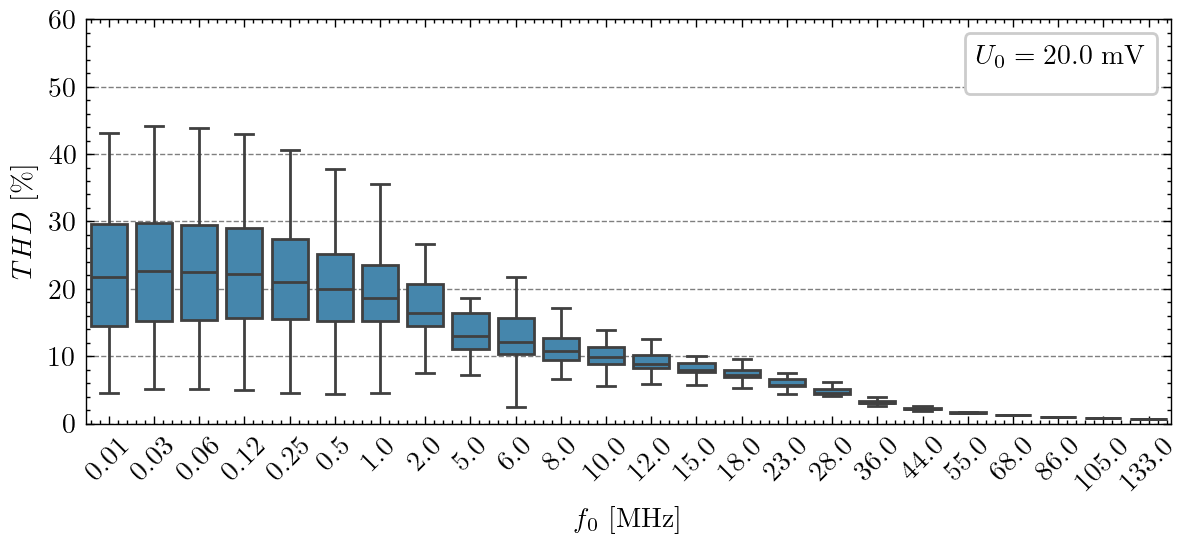

In [21]:
amp     = 0.02
fig, ax = plt.subplots(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = sns.boxplot(data=thd_net[amp], color=BLUE_COLOR, fliersize=0)
_   = ax.set_ylim(0,60)
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.set_ylabel("$THD$ [\%]")
_   = plt.xticks(rotation=45)
ax.legend(title=f"$U_0 = {amp*1000}$ mV", loc='upper right')

fig.savefig(f"plots/amp_freq/{e_type}_net_thd_vs_freq.svg", transparent=True)